# Customer RFM Segmentation for E-Commerce

This project utilizes the RFM (Recency, Frequency, Monetary) method to segment customers of a UK-based online retailer using transactional data between 01/12/2010 and 09/12/2011. Through data analysis and clustering algorithms, we transform raw data into actionable customer profiles, enabling optimized marketing strategies, improved customer retention, and increased sales by identifying and understanding the purchasing behavior of the most valuable customers.

Results are visualized in a [Looker Studio dashboard](https://lookerstudio.google.com/s/kaK3n1F1tMA)

### Opportunity

The dataset encompasses transactions recorded between 2010 and 2011. Our main goal is to enhance marketing effectiveness and increase sales through customer segmentation. To achieve this, we transform the raw transactional data into a customer-focused format by engineering new features that support the identification of distinct customer segments using clustering algorithms.

This segmentation enables us to uncover unique customer profiles and gain insights into their behaviors and preferences.



### **Dataset Description:**

The dataset consist of 541,909 entries and 8 columns.

| **Column**    | **Description**                                                                                   |
|----------------|---------------------------------------------------------------------------------------------------|
| Invoice        | Code representing each unique transaction. If this code starts with letter 'C', it indicates a cancellation. |
| StockCode      | Code uniquely assigned to each distinct product.                                                  |
| Description    | Description of each product.                                                                      |
| Quantity       | The number of units of a product in a transaction.                                                |
| InvoiceDate    | The date and time of the transaction.                                                             |
| Price          | The unit price of the product in sterling.                                                        |
| Customer ID     | Identifier uniquely assigned to each customer.                                                   |
| Country        | The country where each transaction took place.                                                   |


## Setup and Initialization

In [61]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import iplot

import warnings
warnings.filterwarnings('ignore')

## Initial Data Analysis

In [62]:
# Load the dataset and dataset overview
df = pd.read_parquet('xlsx_to_parquet/online_retail_II.parquet')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  string        
 1   StockCode    541910 non-null  category      
 2   Description  540456 non-null  category      
 3   Quantity     541910 non-null  int16         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float32       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  category      
dtypes: category(3), datetime64[ns](1), float32(1), float64(1), int16(1), string(1)
memory usage: 18.4 MB


## Data Cleaning and Transformation

### Handling Missing Values

In [64]:
# Percetage of missing values
missing_percentage = df[['Customer ID', 'Description']].isnull() \
    .mean() * 100

missing_percentage

Customer ID    24.926648
Description     0.268310
dtype: float64

In [65]:
# Saving the missing values to a CSV file
missing_values = df[['Customer ID', 'Description']].isnull().to_csv('missing_values.csv', index=False)

# Drop missing values
df.dropna(inplace = True)

**Customer ID (24.93% missing values) and Description (0.27% missing values)** 
- Both columns are essential for clustering customers. Therefore, missing values in the dataset are removed.

### Handling Duplicates

In [66]:
# Displaying the number of duplicate rows
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

The dataset contains 5225 duplicate rows that need to be removed.


In [67]:
# Drop duplicated rows
df.drop_duplicates(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401605 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      401605 non-null  string        
 1   StockCode    401605 non-null  category      
 2   Description  401605 non-null  category      
 3   Quantity     401605 non-null  int16         
 4   InvoiceDate  401605 non-null  datetime64[ns]
 5   Price        401605 non-null  float32       
 6   Customer ID  401605 non-null  float64       
 7   Country      401605 non-null  category      
dtypes: category(3), datetime64[ns](1), float32(1), float64(1), int16(1), string(1)
memory usage: 16.8 MB


**10,062 Duplicates rows**
- The presence of identical transaction times, suggests that these might be data recording errors rather than genuine repeated transactions. Therefore, duplicate rows must be removed.

### Identifying Stock Codes

In [68]:
# Number of unique StockCodes
nunique_stock_codes = df['StockCode'].nunique()
print(f"Number of unique StockCodes: {nunique_stock_codes}")

Number of unique StockCodes: 3684


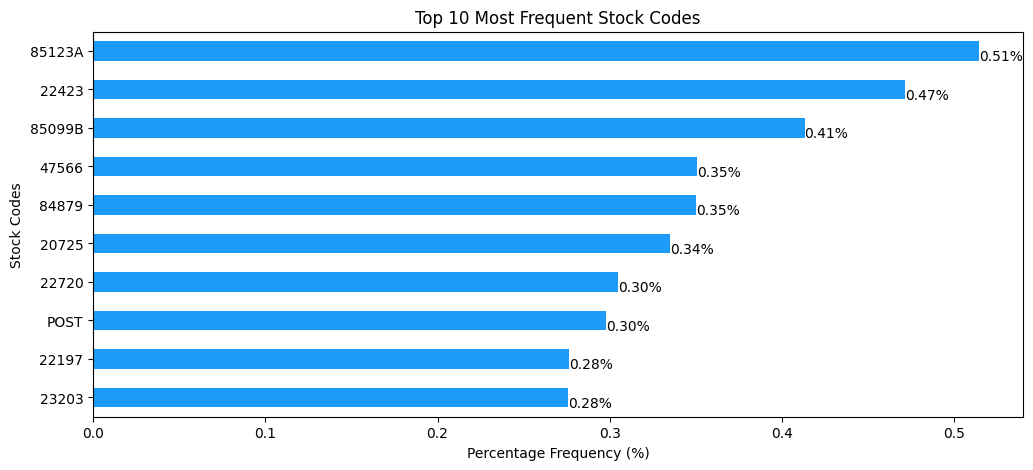

In [69]:
# Finding the top 10 most frequent stock codes
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100

# Plotting the top 10 most frequent stock codes
plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='#1C9BF9')

# Adding the percentage frequency on the bars
for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

In [70]:
# Values of numeric characteres in unique stock codes
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()
numeric_char_counts_in_unique_codes

5    3676
0       7
1       1
Name: count, dtype: int64

In [71]:
# Anomalous stock codes
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

for code in anomalous_stock_codes:
    print(code)

POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [72]:
# Calculating the percentage of records with anomalous stock codes
percentage_anomalous_stock_codes = len(df[df['StockCode'].isin(anomalous_stock_codes)]) / len(df) * 100
print(f"Percentage of records with anomalous stock codes: {percentage_anomalous_stock_codes:.2f}%")

Percentage of records with anomalous stock codes: 0.48%


In [73]:
# Removing rows with anomalous stock codes
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

len(df)

399689

### Inferences on Stock Codes:

- **Product Variety:** The dataset contains 3684 unique stock codes. This diversity can potentially lead to the identification of distinct customers clusters, with preferences for different types of products.

- **Most Frequent Stock Codes:** A closer look at the top 10 most frequent stock codes can offer insights into the popular products or categories that are frequently purchased by customers.

- **Stock Codes Anomalies:** We observe that while most stock codes are composed of 5 or 6 characters, there are some anomalies like the code 'BANK CHANGES', 'POST' (perhaps postage fees) These anomalies might represent services or non-product transactions rather than actual products.

- **Percentage of records with anomalous Stock Codes:** Only 0.48%, have anomalous stock codes, which deviate from the typical format observed in the majority of the data.

We remove the anomalous stock codes since there's a negligible amount of stock codes

### Handling Cancelled Transactions

In [74]:
# Filter out the rows with Invoice values that start with 'C' and create a new column 'Transaction_Status' indicating the status of the transaction
df['Transaction_Status'] = np.where(df['Invoice'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

# Analyze the 'Cancelled' transactions
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop(['Customer ID', 'InvoiceDate'], axis=1)

,Quantity,Price
count,8506.000000,8506.000000
mean,-16.063837,4.440148
min,-15459.000000,0.030000
25%,-6.000000,1.450000
50%,-2.000000,2.550000
75%,-1.000000,4.950000
max,-1.000000,295.000000
std,227.340894,9.199141


In [75]:
# Total price of each transaction
df['TotalPrice'] = df['Quantity'] * df['Price']

# Check shape of transactions with TotalPrice negative
print(f'Shape of transactions with TotalPrice negative: {df[df["TotalPrice"] < 0].shape}')

# Check sum of TotalPrice with negative values
print(f'Sum of TotalPrice with negative values: {df[df["TotalPrice"] < 0]["TotalPrice"].sum()}')

# Check sum of TotalPrice with Transaction_Status as Cancelled
print(f'Sum of TotalPrice with Transaction_Status as Cancelled: {df[df["Transaction_Status"] == "Cancelled"]["TotalPrice"].sum()}')

Shape of transactions with TotalPrice negative: (8506, 10)
Sum of TotalPrice with negative values: -267278.40625
Sum of TotalPrice with Transaction_Status as Cancelled: -267278.40625


In [76]:
# Cancelled transactions percentage
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100
cancelled_percentage

2.128154640232781

### Inferences

- We can see that even thought the percentage of cancelled transactions is low, the total money is signiflicantly high.

The strategy is to retain these cancelled transactions in the dataset, marking them distinctly to facilitate further analysis. This approach will:

- Enhance feature engineering metrics.
- The sum of total spend by customer will be balanced with the transaction of order in the first place.
- Identify products with high cancellation rating.

### Cleaning Description Column

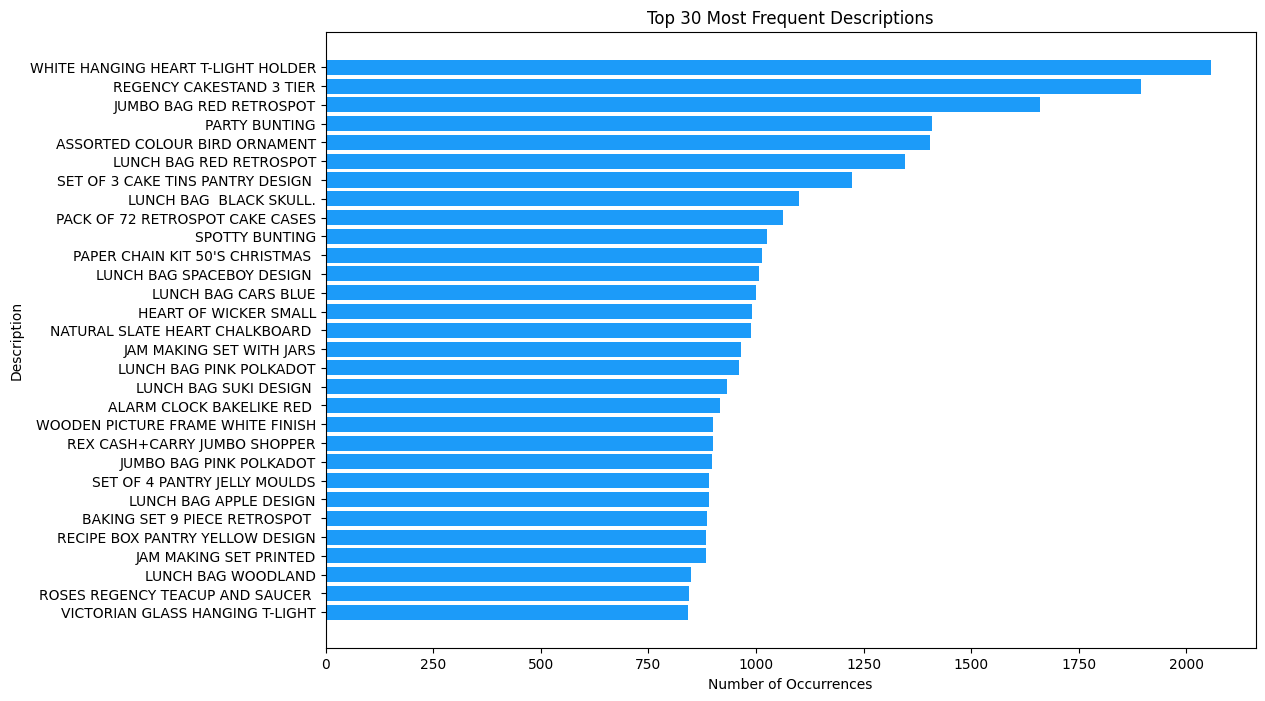

In [77]:
# Calculate the occurrence of each unique description and sort them
description_counts = df['Description'].value_counts()

# Get the top 30 descriptions
top_30_descriptions = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#1C9BF9')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()

In [78]:
# Finding unique descriptions containing lowercase letters
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(c.islower() for c in str(desc))]

print("Unique descriptions containing lowercase letters:")
print("-" * 50)
for desc in lowercase_descriptions:
    print(desc)

Unique descriptions containing lowercase letters:
--------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


In [79]:
# Calculating the number and percentage of records with service descriptions
service_descriptions = ["Next Day Carriage", "High Resolution Image"]

number_service_descriptions = df[df['Description'].isin(service_descriptions)].shape[0]
percentage_service_descriptions = (number_service_descriptions / df.shape[0]) * 100
print(f"Number of records with service descriptions: {number_service_descriptions}")
print(f"Percentage of records with service descriptions: {percentage_service_descriptions:.2f}%")

# Removing rows with descriptions containing service descriptions
df = df[~df['Description'].isin(service_descriptions)]

Number of records with service descriptions: 83
Percentage of records with service descriptions: 0.02%


In [80]:
df.shape[0]

399606

### Inferences

- The most frequent descriptions are generally household items, particularly those associated with kitchenware, lunch bags, and decorative items.

- All the descriptions are in uppercase, which might be a standardized format for entering product descriptions in the database. It would be prudent to check if there are descriptions entered in lowercase or a mix of case styles.

- Upon reviewing the descriptions that contain lowecase characters, it is evident that some entries are not product descriptions, such as "Next Day Carriage" and "High Resolution Image". Therefore, we removed rows with this descriptions.

## Comparing Stock Codes with Descriptions

In [81]:
# Unique values in each column
{columns: len(df[columns].unique()) for columns in df.columns}

{'Invoice': 21784,
 'StockCode': 3674,
 'Description': 3886,
 'Quantity': 432,
 'InvoiceDate': 20132,
 'Price': 370,
 'Customer ID': 4363,
 'Country': 37,
 'Transaction_Status': 2,
 'TotalPrice': 3745}

In [82]:
# Ensure columns are of type string
df['StockCode'] = df['StockCode'].astype(str)
df['Description'] = df['Description'].astype(str)

# Count how many StockCode are associated with each Description
description_counts = df.groupby('Description')['StockCode'].nunique().reset_index()
description_counts.rename(columns={'StockCode': 'StockCode_Count'}, inplace=True)

# Filter descriptions shared by more than one StockCode
shared_descriptions = description_counts[description_counts['StockCode_Count'] > 1]

# Show shared descriptions
print("Descriptions shared by multiple StockCodes:")
print("-" * 50)
print(shared_descriptions)

# Get details of the StockCode associated with these Descriptions
shared_desc_details = df[df['Description'].isin(shared_descriptions['Description'])][['StockCode', 'Description']].drop_duplicates().sort_values(by='Description')

# Show details
print("\nStockCode details with shared descriptions:")
print("-" * 50)
print(shared_desc_details)

Descriptions shared by multiple StockCodes:
--------------------------------------------------
                          Description  StockCode_Count
827      COLOURING PENCILS BROWN TUBE                2
829        COLUMBIAN CANDLE RECTANGLE                2
830            COLUMBIAN CANDLE ROUND                2
1080  EAU DE NILE JEWELLED PHOTOFRAME                2
1324     FRENCH FLORAL CUSHION COVER                 2
1327    FRENCH LATTICE CUSHION COVER                 2
1345              FROSTED WHITE BASE                 2
2018   METAL SIGN,CUPCAKE SINGLE HOOK                3
2332  PAPER LANTERN 9 POINT SNOW STAR                2
2461    PINK FAIRY CAKE CUSHION COVER                2
2466    PINK FLOCK GLASS CANDLEHOLDER                2
2472       PINK FLOWERS RABBIT EASTER                2
2796          RETRO PLASTIC 70'S TRAY                2
2797         RETRO PLASTIC DAISY TRAY                2
2799         RETRO PLASTIC POLKA TRAY                2
2872     ROUND BLUE CLOCK

In [83]:
# Convert StockCode to string
df['StockCode'] = df['StockCode'].astype(str)

# Group by StockCode and count the uniques Descriptions
stock_code_description = df.groupby('StockCode')['Description'].nunique().reset_index()
stock_code_description.rename(columns={'Description': 'Unique_Descriptions_Count'}, inplace= True)

# Filtering the stock codes with more than 1 unique description
multiple_descriptions = stock_code_description[stock_code_description['Unique_Descriptions_Count'] > 1]

# Displaying the stock codes with more than 1 unique description
print("Stock codes with more than 1 unique description:")
print("-" * 50)

print(multiple_descriptions)

# Obtaining the details of the stock codes with more than 1 unique description
multiple_descriptions_details = multiple_descriptions['StockCode']
details = df[df['StockCode'].isin(multiple_descriptions_details)][['StockCode', 'Description']].drop_duplicates().sort_values(by='StockCode')

print("\nDetails of the stock codes with more than 1 unique description:")
print("-" * 50)
print(details)

Stock codes with more than 1 unique description:
--------------------------------------------------
     StockCode  Unique_Descriptions_Count
42      16156L                          2
100     17107D                          3
118      20622                          2
170      20725                          2
262      20914                          2
...        ...                        ...
3308    85184C                          2
3309    85185B                          2
3372    90014A                          2
3373    90014B                          2
3374    90014C                          2

[213 rows x 2 columns]

Details of the stock codes with more than 1 unique description:
--------------------------------------------------
       StockCode                          Description
47284     16156L                       WRAP, CAROUSEL
138080    16156L                        WRAP CAROUSEL
315743    17107D         FLOWER FAIRY 5 DRAWER LINERS
347764    17107D    FLOWER FAIRY 5 SUMME

In [84]:
{columns: len(df[columns].unique()) for columns in df.columns}

{'Invoice': 21784,
 'StockCode': 3674,
 'Description': 3886,
 'Quantity': 432,
 'InvoiceDate': 20132,
 'Price': 370,
 'Customer ID': 4363,
 'Country': 37,
 'Transaction_Status': 2,
 'TotalPrice': 3745}

In [85]:
import pandas as pd

# Ensure columns are of type string
df['StockCode'] = df['StockCode'].astype(str)
df['Description'] = df['Description'].astype(str)

# Step 1: Unify multiple descriptions by selecting the most frequent one
most_frequent_desc = df.groupby(['StockCode', 'Description']).size().reset_index(name='Count')
most_frequent_desc = most_frequent_desc.sort_values(['StockCode', 'Count'], ascending=[True, False])
most_frequent_desc = most_frequent_desc.groupby('StockCode').first().reset_index()[['StockCode', 'Description']]

# Update the DataFrame with unified descriptions
df = df.drop(columns=['Description']).merge(most_frequent_desc, on='StockCode', how='left')

# Step 2: Identify and modify shared descriptions
description_counts = df.groupby('Description')['StockCode'].nunique().reset_index()
shared_descriptions = description_counts[description_counts['StockCode'] > 1]['Description']

# Modify shared descriptions by adding the StockCode
df.loc[df['Description'].isin(shared_descriptions), 'Description'] = (
    df['Description'] + " (" + df['StockCode'] + ")"
)

# Step 3: Validate results
# Verify unique values
print("Unique values after cleaning:")
print(f"StockCode: {df['StockCode'].nunique()}")
print(f"Description: {df['Description'].nunique()}")

# Check multiple descriptions
stock_code_description = df.groupby('StockCode')['Description'].nunique().reset_index()
multiple_descriptions = stock_code_description[stock_code_description['Description'] > 1]
if multiple_descriptions.empty:
    print("No StockCode with multiple descriptions.")
else:
    print("Warning: Some StockCode still have multiple descriptions:")
    print(multiple_descriptions)

# Check shared descriptions
description_counts = df.groupby('Description')['StockCode'].nunique().reset_index()
shared_descriptions = description_counts[description_counts['StockCode'] > 1]
if shared_descriptions.empty:
    print("There are no descriptions shared by multiple StockCode.")
else:
    print("Warning: Some descriptions are still shared:")
    print(shared_descriptions)

Unique values after cleaning:
StockCode: 3674
Description: 3674
No StockCode with multiple descriptions.
There are no descriptions shared by multiple StockCode.


### Inferences:

- **StockCodes with multiple Descriptions:** 213 StockCodes have multiple descriptions (196 with 2, 15 with 3, 2 with 4), causing extra Description values
- **Descriptions shared by multiple StockCodes:** 19 descriptions are used by 39 StockCodes

The presence of multiple descriptions per StockCode and shared descriptions across StockCode led to data quality issues, complicating product-level analyses such as identifying top-selling items.

### Strategy:

- For the 213 StockCodes with multiple descriptions, we selected the most frequent Description for each StockCode using a group-by operation and sorting by count.
- For the 19 descriptions shared across 39 StockCode, we appended the StockCode in parentheses to create unique descriptions (e.g., "COLOURING PENCILS BROWN TUBE (10133)" and "COLOURING PENCILS BROWN TUBE (10135)").

## Treating Zero Unit Prices

### 

In [86]:
df['Price'].describe()

count    399606.000000
mean          2.904957
std           4.448796
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: Price, dtype: float64

In [87]:
df[df['Price']==0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000
std,2176.713608


In [88]:
df[df['Price']==0].head(10)

,Invoice,StockCode,Quantity,InvoiceDate,Price,Customer ID,Country,Transaction_Status,TotalPrice,Description
6816,537197,22841,1,2010-12-05 14:02:00,0.0,12647.0,Germany,Completed,0.0,ROUND CAKE TIN VINTAGE GREEN
22536,539263,22580,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom,Completed,0.0,ADVENT CALENDAR GINGHAM SACK
25442,539722,22423,10,2010-12-21 13:45:00,0.0,14911.0,EIRE,Completed,0.0,REGENCY CAKESTAND 3 TIER
29243,540372,22090,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,Completed,0.0,PAPER BUNTING RETROSPOT
29245,540372,22553,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,Completed,0.0,PLASTERS IN TIN SKULLS
34743,541109,22168,1,2011-01-13 15:10:00,0.0,15107.0,United Kingdom,Completed,0.0,ORGANISER WOOD ANTIQUE WHITE
54228,543599,84535B,16,2011-02-10 13:08:00,0.0,17560.0,United Kingdom,Completed,0.0,FAIRY CAKES NOTEBOOK A6 SIZE
86338,547417,22062,36,2011-03-23 10:25:00,0.0,13239.0,United Kingdom,Completed,0.0,CERAMIC BOWL WITH LOVE HEART DESIGN
93491,548318,22055,5,2011-03-30 12:45:00,0.0,13113.0,United Kingdom,Completed,0.0,MINI CAKE STAND HANGING STRAWBERY
98139,548871,22162,2,2011-04-04 14:42:00,0.0,14410.0,United Kingdom,Completed,0.0,HEART GARLAND RUSTIC PADDED


In [89]:
# Removing records with a unit price of zero to avoid potential data entry errors
df = df[df['Price'] > 0]

In [90]:
# Resetting the index of the cleaned dataset
df.reset_index(drop=True, inplace=True)

# Getting the number of rows in the dataframe
df.shape[0]

399573

### Inferences

- The transactions with a unit price of zero are relatively few in number (33 transactions).
- These transactions have a large variability in the quantity of items involved, ranging from 1 to 12540, with a substantial standard deviation.

Given the small number of these transactions and their potential to introduce noise in the data analysis, the strategy should be to remove these transactions from the dataset.

# Feature Engineering

In [91]:
# Displaying the first few rows of the cleaned dataset
df.head()

,Invoice,StockCode,Quantity,InvoiceDate,Price,Customer ID,Country,Transaction_Status,TotalPrice,Description
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Completed,15.299999,WHITE HANGING HEART T-LIGHT HOLDER
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,20.340000,WHITE METAL LANTERN
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Completed,22.000000,CREAM CUPID HEARTS COAT HANGER
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,20.340000,KNITTED UNION FLAG HOT WATER BOTTLE
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,20.340000,RED WOOLLY HOTTIE WHITE HEART.


In [92]:
# First and last date of the dataset
print("Min Date", df["InvoiceDate"].min(), "Max Date", df["InvoiceDate"].max())

Min Date 2010-12-01 08:26:00 Max Date 2011-12-09 12:50:00


## Customer Behavioral Features (RFM)

### Recency

This metric indicates how recently a customer has made a purchase. A lower recency value means the customer has purchased more recently, indicating higher engagement with the brand.

In [93]:
# Recency calculation and customer data creation
today_date = df.agg({"InvoiceDate":"max"})

# Calculate the number of days since the last purchase
customer_data = (today_date - df.groupby("Customer ID") \
           .agg({"InvoiceDate":"max"})) \
            .rename(columns = {"InvoiceDate":"Recency"})

customer_data["Recency"] = customer_data["Recency"] \
    .apply(lambda x: x.days)

customer_data.head()

,Recency
Customer ID,
12346.0,325
12347.0,1
12348.0,74
12349.0,18
12350.0,309


### Frecuency

There are two features that quantify the frequency of a customer's engagement with the retailer:

- **Total Transactions:** This feature represents the total number of transactions made by a customer. It helps in understanding the engagement level of a customer with the retailer.

- **Total Products Purchased:** This feature indicates the total number of products (sum of quantities) purchased by a customer across all transactions. It gives an insight into the customer's buying behavior in terms of the volume of products purchased.

In [94]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('Customer ID')['Invoice'] \
                    .nunique() \
                        .reset_index()
total_transactions.rename(columns={'Invoice': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('Customer ID')['Quantity'] \
                            .sum() \
                                .reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='Customer ID')
customer_data = pd.merge(customer_data, total_products_purchased, on='Customer ID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Recency,Total_Transactions,Total_Products_Purchased
0,12346.0,325,2,0
1,12347.0,1,7,2458
2,12348.0,74,4,2332
3,12349.0,18,1,630
4,12350.0,309,1,196


### Monetary

There are two features that represent the monetary aspect of customer's transactions:

- **Total Spend:** This feature represents the total amount of money spent by each customer. It is calculated as the sum of the product of UnitPrice and Quantity for all transactions made by a customer. This feature is crucial as it helps in identifying the total revenue generated by each customer, which is a direct indicator of a customer's value to the business.

- **Average Transaction Value:** This feature is calculated as the **Total Spend** divided by the Total Transactions for each customer. It indicates the average value of a transaction carried out by a customer. This metric is useful in understanding the spending behavior of customers per transaction, which can assist in tailoring marketing strategies and offers to different customer segments based on their average spending patterns.

In [95]:
# Calculate the total spend by each customer
total_spend = df.groupby('Customer ID')['TotalPrice'] \
            .sum() \
                .reset_index()

total_spend.rename(columns={'TotalPrice': 'Total_Spend'}, inplace=True)

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='Customer ID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='Customer ID')
customer_data = pd.merge(customer_data, average_transaction_value[['Customer ID', 'Average_Transaction_Value']], on='Customer ID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Recency,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0,0.000000,0.000000
1,12347.0,1,7,2458,4310.000000,615.714286
2,12348.0,74,4,2332,1437.239990,359.309998
3,12349.0,18,1,630,1457.550049,1457.550049
4,12350.0,309,1,196,294.399994,294.399994


In [96]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = df.groupby('Customer ID')['StockCode'] \
                            .nunique() \
                                .reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='Customer ID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Recency,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,325,2,0,0.000000,0.000000,1
1,12347.0,1,7,2458,4310.000000,615.714286,103
2,12348.0,74,4,2332,1437.239990,359.309998,21
3,12349.0,18,1,630,1457.550049,1457.550049,72
4,12350.0,309,1,196,294.399994,294.399994,16


## Cancellation Insights

- **Cancellation Frequency:** This metric represents the total number of transactions a customer has canceled. Understanding the frequency of cancellations can help us identify customers who are more likely to cancel transactions. This could be an indicator of dissatisfaction or other issues, and understanding this can help us tailor strategies to reduce cancellations and enhance customer satisfaction.

- **Cancellation Rate:** This represents the proportion of transactions that a customer has canceled out of all their transactions. This metric gives a normalized view of cancellation behavior. A high cancellation rate might be indicative of an unsatisfied customer segment. By identifying these segments, we can develop targeted strategies to improve their shopping experience and potentially reduce the cancellation rate.

In [97]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('Customer ID')['Invoice'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('Customer ID')['Invoice'].nunique().reset_index()
cancellation_frequency.rename(columns={'Invoice': 'Cancellation_Frequency'}, inplace=True)

# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='Customer ID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['Invoice']

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Recency,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0,0.000000,0.000000,1,1.0,0.5
1,12347.0,1,7,2458,4310.000000,615.714286,103,0.0,0.0
2,12348.0,74,4,2332,1437.239990,359.309998,21,0.0,0.0
3,12349.0,18,1,630,1457.550049,1457.550049,72,0.0,0.0
4,12350.0,309,1,196,294.399994,294.399994,16,0.0,0.0


In [98]:
# Number of customers who cancelled at least one transaction
customers_who_cancelled = customer_data[customer_data['Cancellation_Rate'] > 0]
print(f"Number of customers who cancelled at least one transaction: {customers_who_cancelled.shape[0]}")
customers_who_cancelled.head(15)

Number of customers who cancelled at least one transaction: 1534


,Customer ID,Recency,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0,0.000000,0.000000,1,1.0,0.500000
5,12352.0,35,8,463,1265.410034,158.176254,57,1.0,0.125000
12,12359.0,7,6,1599,6182.979980,1030.496663,214,2.0,0.333333
15,12362.0,2,13,2180,4665.580078,358.890775,200,3.0,0.230769
25,12375.0,2,3,175,375.419983,125.139994,13,1.0,0.333333
28,12379.0,81,3,401,775.289978,258.429993,38,1.0,0.333333
29,12380.0,21,5,1109,2423.560059,484.712012,76,1.0,0.200000
30,12381.0,4,4,772,1433.459961,358.364990,69,1.0,0.250000
31,12383.0,184,6,1515,1617.310059,269.551676,83,1.0,0.166667
32,12384.0,28,3,117,406.160004,135.386668,25,1.0,0.333333


## Seasonality

The seasonality in customers' purchasing behaviors can offer invaluable insights for tailoring marketing strategies and enhancing customer satisfaction. Here are the two features to introduce:

- **Monthly_Spending_Mean:** This is the average amount a customer spends monthly. It helps us gauge the general spending habit of each customer. A higher mean indicates a customer who spends more, potentially showing interest in premium products, whereas a lower mean might indicate a more budget-conscious customer.

- **Monthly_Spending_Std:** This feature indicates the variability in a customer's monthly spending. A higher value signals that the customer's spending fluctuates significantly month-to-month, perhaps indicating sporadic large purchases. In contrast, a lower value suggests more stable, consistent spending habits. Understanding this variability can help in crafting personalized promotions or discounts during periods they are expected to spend more.

In [99]:
# Extract month and year from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = df.groupby(['Customer ID', 'Year', 'Month'])['TotalPrice'].sum().reset_index()

# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('Customer ID')['TotalPrice'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Remove the Year and Month columns from the original dataframe
df.drop(columns=['Year', 'Month'], inplace=True)

In [100]:
# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='Customer ID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Recency,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std
0,12346.0,325,2,0,0.000000,0.000000,1,1.0,0.5,0.000000,0.000000
1,12347.0,1,7,2458,4310.000000,615.714286,103,0.0,0.0,615.714294,341.070770
2,12348.0,74,4,2332,1437.239990,359.309998,21,0.0,0.0,359.309998,203.875687
3,12349.0,18,1,630,1457.550049,1457.550049,72,0.0,0.0,1457.550049,0.000000
4,12350.0,309,1,196,294.399994,294.399994,16,0.0,0.0,294.399994,0.000000


## Customer Dataset Description

| **Column**                    | **Description**                                                                                      |
|-------------------------------|------------------------------------------------------------------------------------------------------|
| Customer ID                   | Identifier uniquely assigned to each customer, used to distinguish individual customers.             |
| Recency                       | The number of days that have passed since the customer's last purchase.                             |
| Total_Transactions            | The total number of transactions made by the customer.                                              |
| Total_Products_Purchased      | The total quantity of products purchased by the customer across all transactions.                   |
| Total_Spend                   | The total amount of money the customer has spent across all transactions.                           |
| Average_Transaction_Value     | The average value of the customer's transactions, calculated as total spend divided by transactions. |
| Unique_Products_Purchased     | The number of different products the customer has purchased.                                        |
| Cancellation_Frequency        | The total number of transactions that the customer has cancelled.                                   |
| Cancellation_Rate             | The proportion of transactions that the customer has cancelled, calculated as cancellations/total.  |
| Monthly_Spending_Mean         | The average monthly spending of the customer.                                                       |
| Monthly_Spending_Std          | The standard deviation of the customer's monthly spending, indicating variability.                  |


## Outlier Detection

For a better understanding of the data, we will apply Isolation Forest to detect outliers.

**Isolation Forest** algorithm works well for multi-dimensional data and is computationally efficient. It isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

In [101]:
# Calculate descriptive statistics
stats = customer_data[['Recency', 'Total_Transactions', 'Total_Spend']].describe().T
stats['median'] = customer_data[['Recency', 'Total_Transactions', 'Total_Spend']].median()
stats = stats[['mean', 'median', 'std', 'min', 'max']]
print(stats.round(2))

                       mean  median      std     min        max
Recency               91.17   49.00   100.97     0.0     373.00
Total_Transactions     4.99    3.00     9.08     1.0     242.00
Total_Spend         1894.60  641.79  8266.05 -1192.2  278778.03


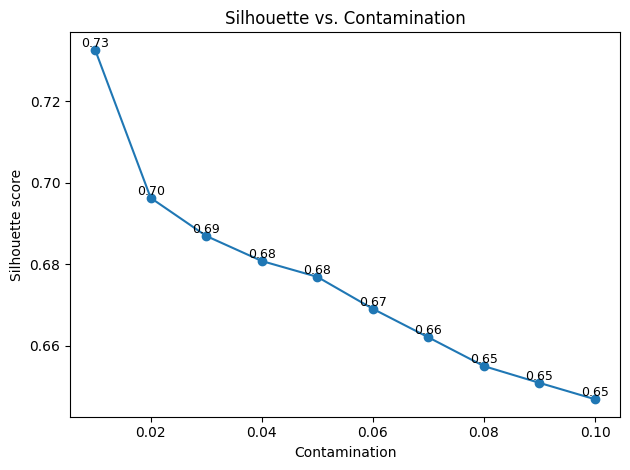

In [102]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Select features for anomaly detection
X = customer_data[['Recency', 'Total_Transactions', 'Total_Spend']]

# Visualize the process of finding the optimal number of percentage of contamination
contaminations = np.linspace(0.01, 0.10, 10)
scores = []

for c in contaminations:
    iso = IsolationForest(contamination=c, random_state=0)
    mask = iso.fit_predict(X) == 1
    km = KMeans(n_clusters=3, random_state=0).fit(X[mask])
    scores.append(silhouette_score(X[mask], km.labels_))

# Plot
plt.plot(contaminations, scores, marker='o')
for x, y in zip(contaminations, scores):
    plt.text(x, y, f"{y:.2f}", ha='center', va='bottom', fontsize=9)

plt.xlabel("Contamination")
plt.ylabel("Silhouette score")
plt.title("Silhouette vs. Contamination")
plt.tight_layout()
plt.show()

In [103]:
# Fit the Isolation Forest model
model = IsolationForest(contamination=0.01, random_state=42)
model.fit(X)

# Predict anomalies
anomalies = model.predict(X)
anomalies = pd.Series(anomalies, index=customer_data.index)
customer_data['Outlier'] = anomalies
customer_data['Outlier'] = customer_data['Outlier'].map({1: 0, -1: 1})  # Convert to binary (0 for normal, 1 for anomaly)

# Display the first few rows of the customer_data dataframe
customer_data.head(10)

,Customer ID,Recency,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Outlier
0,12346.0,325,2,0,0.000000,0.000000,1,1.0,0.500,0.000000,0.000000,0
1,12347.0,1,7,2458,4310.000000,615.714286,103,0.0,0.000,615.714294,341.070770,0
2,12348.0,74,4,2332,1437.239990,359.309998,21,0.0,0.000,359.309998,203.875687,0
3,12349.0,18,1,630,1457.550049,1457.550049,72,0.0,0.000,1457.550049,0.000000,0
4,12350.0,309,1,196,294.399994,294.399994,16,0.0,0.000,294.399994,0.000000,0
5,12352.0,35,8,463,1265.410034,158.176254,57,1.0,0.125,316.352509,134.700638,0
6,12353.0,203,1,20,89.000000,89.000000,4,0.0,0.000,89.000000,0.000000,0
7,12354.0,231,1,530,1079.400024,1079.400024,58,0.0,0.000,1079.400024,0.000000,0
8,12355.0,213,1,240,459.399994,459.399994,13,0.0,0.000,459.399994,0.000000,0
9,12356.0,22,3,1573,2487.429932,829.143311,52,0.0,0.000,829.143311,991.462585,0


In [104]:
# Percentage of outliers
outlier_percentage = (customer_data['Outlier'].sum() / customer_data.shape[0]) * 100
print(f"Percentage of outliers: {outlier_percentage:.2f}%")

# Print the number of outliers
print(f"Number of outliers: {customer_data['Outlier'].sum()}")

Percentage of outliers: 1.01%
Number of outliers: 44


In [105]:
# Print customer data with outliers
outliers = customer_data[customer_data['Outlier'] == 1]
print("Outliers:")
print(outliers[['Customer ID', 'Recency', 'Total_Transactions', 'Total_Spend']])

Outliers:
      Customer ID  Recency  Total_Transactions    Total_Spend
55        12415.0       23                  24  123638.179688
100       12471.0        1                  45   16323.520508
328       12748.0        0                 217   29819.990234
448       12921.0        3                  50   16389.740234
456       12931.0       21                  19   33544.808594
485       12971.0        3                  88   10933.759766
566       13089.0        2                 118   57322.128906
570       13093.0      266                  13    7741.469727
574       13098.0        0                  41   28658.878906
799       13408.0        1                  75   27888.380859
1001      13694.0        3                  57   62961.539062
1058      13767.0        1                  52   16945.710938
1063      13777.0        0                  40   25758.099609
1074      13798.0        0                  63   36352.871094
1291      14088.0        9                  14   50415.48828

In [106]:
# Separate outliers
outliers = customer_data[customer_data['Outlier'] == 1]

customer_data_cleaned = customer_data.copy()

# Drop the Outlier column
customer_data_cleaned.drop(columns=['Outlier'], inplace=True)
customer_data_cleaned.reset_index(drop=True, inplace=True)

customer_data_cleaned.shape[0]

4362

### Inferences

The curve clearly shows that the higher the percentage of outliers to remove, the worse the internal "quality" of the clusters (silhouette score) becomes. Specifically:

- Maximum peak at 0.01 (≈0.73).

- From there, as the proportion of data removed increases, the silhouette score drops fairly steadily.

### Strategy

It is a good practice to handle these outliers to prevent them from affecting the clusters' quality significantly. In this case the outliers detected are customers who spend the most, the most important ones. Therefore the strategy will be to keep them and consider applying Hierarchical clustering too.

## Correlation Analysis

Before we proceed to KMeans clustering, it's essential to check the correlation between features in our dataset.

In [107]:
from plotly import express as px

# Calcular la matriz de correlación (redondeada)
corr = customer_data_cleaned.drop(columns=['Customer ID']).corr().round(2)

# Crear máscara para mantener solo la mitad inferior
mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
corr_masked = corr.mask(mask)

# Crear heatmap
fig = px.imshow(
    corr_masked,
    text_auto=True,
    color_continuous_scale=["#ffffff", "#1C9BF9"],
    aspect="equal",
    labels=dict(x="", y="", color="Correlación")
)

# Personalizar layout
fig.update_layout(
    width=900,
    height=900,
    xaxis_side="bottom",  # Que aparezcan abajo
    font=dict(size=15),
    xaxis=dict(tickfont=dict(family="Arial", size=14)),
    yaxis=dict(tickfont=dict(family="Arial", size=14))
)

# Cambiar fuente de los números dentro del heatmap
fig.update_traces(
    textfont=dict(family="Arial", size=18),
    texttemplate="%{z:.2f}"
)

# Mantener etiquetas horizontales
fig.update_xaxes(tickangle=270)

fig.show()

### Inferences

- **Recency:** The more recent the customer’s last purchase, the more transactions (-0.26), products (-0.14), and money (-0.13) they spent. A shorter recency is associated with higher engagement, and customers who returned recently also bought a wider variety of products (-0.30).
- **Total_Transactions:** More transactions are tied to more products purchased (0.57), higher total spending (0.55), a wider range of items (0.70), and a higher number of cancellations (0.35). Frequent customers tend to be high spenders who explore more products and are also more likely to cancel.
- **Total_Products_Purchased:** Buying more products correlates strongly with total spend (0.92), showing that product quantity drives revenue. It’s also linked to greater variety (0.44), more transactions (0.57), and slightly with more cancellations (0.35). These customers tend to be somewhat more recent (-0.14).
- **Total_Spend:** Strongly tied to product volume (0.92), purchase variety (0.40), and both average (0.79) and variable (0.82) monthly spending. High spenders also transact more (0.55) and have more recent activity (-0.13). This is the clearest indicator of high-value customers.
- **Average_Transaction_Value:** Closely associated with average monthly spending (0.79) and moderately with total spend (0.44). This feature reflects purchasing power per transaction, but has minimal correlation with frequency or recency.
- **Unique_Products_Purchased:** A wider range of products is linked to more transactions (0.70), total spend (0.40), and product count (0.44). These customers tend to cancel slightly more (0.53) and have made more recent purchases (-0.30).
- **Cancellation_Frequency:** More frequent cancellations correlate with product variety (0.53), total product count (0.35), and number of transactions (0.35). These customers are active but may have issues with satisfaction. They also tend to have bought more recently (-0.19).
- **Cancellation_Rate:** Only moderately associated with cancellation frequency (0.45), and largely independent of recency (-0.01), spend (0.03), or transaction volume. It likely reflects a behavioral pattern not directly tied to purchase value.
- **Monthly_Spending_Mean:** Strongly correlated with total spend (0.73), transaction value (0.79), and product quantity (0.62). This metric reflects stable, high-value customer behavior and a pattern of regular spending.
- **Monthly_Spending_Std:** High variability in monthly spending correlates with higher overall spending (0.82), higher monthly average (0.66), and slightly more products (0.69). These customers tend to be recent buyers (-0.12) with inconsistent but impactful purchasing patterns.


## StandardScaler Application

K-means relies heavily on the concept of 'distance' between data points to form clusters. When features are not on a similar scale, features with larger values can disproportionately influence the clustering outcome, potentially leading to incorrect groupings. That's why data must be standardized.

In [108]:
from sklearn.preprocessing import StandardScaler

# Feature selection
RFM_features = ['Customer ID','Recency', 'Total_Transactions', 'Total_Spend']
customer_RFM = customer_data_cleaned[RFM_features]

# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['Customer ID']

# List of columns that need to be scaled
columns_to_scale = customer_RFM.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_RFM_scaled = customer_RFM.copy()

# Applying the scaler to the necessary columns in the dataset
customer_RFM_scaled[columns_to_scale] = scaler.fit_transform(customer_RFM_scaled[columns_to_scale])

# Set 'Customer ID' as index
customer_RFM_scaled.set_index('Customer ID', inplace=True)

# Display the first few rows of the scaled data
customer_RFM_scaled.head()

,Recency,Total_Transactions,Total_Spend
Customer ID,,,
12346.0,2.316176,-0.329598,-0.229229
12347.0,-0.893205,0.220952,0.292240
12348.0,-0.170103,-0.109378,-0.055337
12349.0,-0.724811,-0.439709,-0.052880
12350.0,2.157688,-0.439709,-0.193610


## Determining the Optimal Number of Clusters

To ascertain the optimal number of clusters (k) for segmenting customers, I will explore two renowned methods:

- **Elbow Method**

- **Silhouette Method**

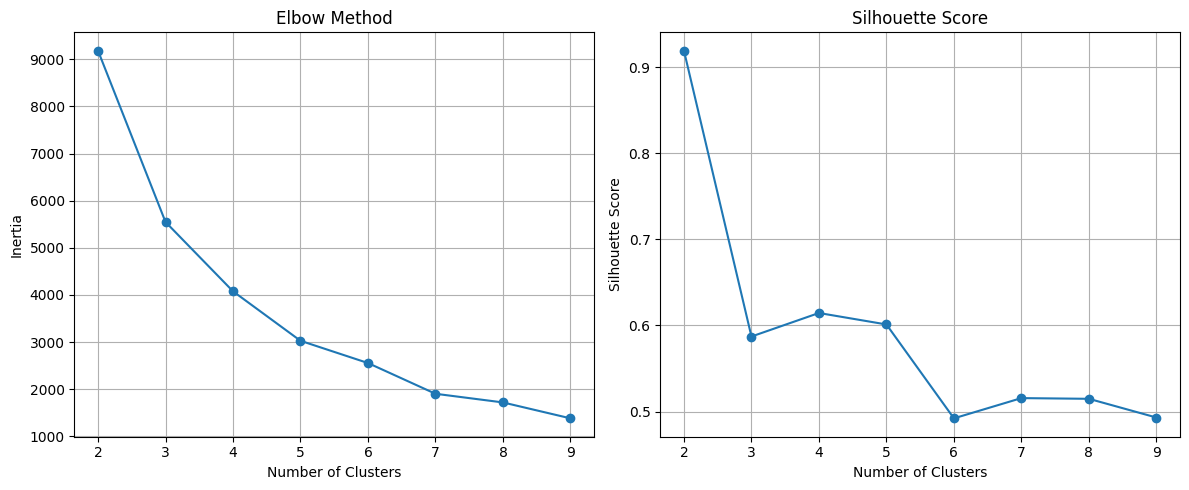

In [109]:
# Elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Range of clusters to test
range_n_clusters = range(2, 10)
inertia = []
silhouette_scores = []

# Loop through the range of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(customer_RFM_scaled)
    
    # Calculate inertia
    inertia.append(kmeans.inertia_)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(customer_RFM_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plotting the elbow method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.tight_layout()
plt.show()

### Inferences

**Elbow: k between 4 and 5:** The inertia drops sharply from k = 2 to k = 4, and then begins to flatten from k = 5 onward. The point where the inertia starts to diminish at a slower rate is around k = 4 or 5. This suggests that the optimal number of clusters is likely between 4 and 5, as adding more clusters beyond this point yields smaller improvements.

**Silhouette: k = 3 clearly wins:** Among higher values, k = 4 has the next highest silhouette score, indicating relatively well-separated and cohesive clusters. After k = 4, the silhouette score declines, showing reduced clustering quality.

Although k = 2 gives the highest silhouette score, a choice of k = 4 provides a strong balance between cluster cohesion and model complexity. 4 clusters is the best option for a RFM Segmentation.

## Applying Clustering KMeans

In [110]:
from collections import Counter

# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=42)
kmeans.fit(customer_RFM_scaled)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

freq_sorted = cluster_frequencies.most_common()  
#    freq_sorted = [(3, 50), (1, 45), (4, 40), (0, 30), (2, 25)]

label_mapping = {old_label: new_label for new_label, (old_label, _) in enumerate(freq_sorted)}
#    label_mapping = {3:0, 1:1, 4:2, 0:3, 2:4}

# Apply that mapping to each label generated by KMeans
original_labels = kmeans.labels_                    # array([2, 0, 3, 3, 1, ...])
new_labels = np.array([label_mapping[label] for label in original_labels])

# Add the new labels to the original DataFrame
customer_RFM_scaled['cluster'] = new_labels
customer_data_cleaned['cluster'] = new_labels

customer_data_cleaned.head()

,Customer ID,Recency,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,cluster
0,12346.0,325,2,0,0.000000,0.000000,1,1.0,0.5,0.000000,0.000000,1
1,12347.0,1,7,2458,4310.000000,615.714286,103,0.0,0.0,615.714294,341.070770,0
2,12348.0,74,4,2332,1437.239990,359.309998,21,0.0,0.0,359.309998,203.875687,0
3,12349.0,18,1,630,1457.550049,1457.550049,72,0.0,0.0,1457.550049,0.000000,0
4,12350.0,309,1,196,294.399994,294.399994,16,0.0,0.0,294.399994,0.000000,1


In [111]:
print(customer_data_cleaned['cluster'].value_counts().sort_index())

cluster
0    3071
1    1073
2     207
3      11
Name: count, dtype: int64


In [112]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

features = customer_RFM_scaled.values

# Calculate the metrics for K-Means clustering
kmeans_silhouette = silhouette_score(features, kmeans.labels_)
kmeans_calinski = calinski_harabasz_score(features, kmeans.labels_)
kmeans_davies = davies_bouldin_score(features, kmeans.labels_)

# Print the metrics
print("K-Means Clustering Metrics:")
print("Silhouette Score K-Means:", kmeans_silhouette)
print("Calinski-Harabasz Score K-Means:", kmeans_calinski)
print("Davies-Bouldin Score K-Means:", kmeans_davies)

K-Means Clustering Metrics:
Silhouette Score K-Means: 0.6757703132446826
Calinski-Harabasz Score K-Means: 3732.482873990765
Davies-Bouldin Score K-Means: 0.7266546821675622


In [113]:
import plotly.express as px
fig = px.scatter_3d(customer_RFM_scaled, x='Recency', y='Total_Transactions', z='Total_Spend', color='cluster')
fig.show()

In [114]:
# Print the mean values of each cluster for insights
print("Mean values of each cluster:")
print(customer_data_cleaned.groupby('cluster')[['Recency', 'Total_Transactions', 'Total_Spend']].mean())

Mean values of each cluster:
            Recency  Total_Transactions    Total_Spend
cluster                                               
0         41.926083            4.260501    1299.026855
1        248.568500            1.778192     457.803375
2         10.536232           27.101449   11667.638672
3          4.090909          107.181818  124411.726562


In [115]:
# Rename the cluster column
customer_data_cleaned.rename(columns={'cluster': 'RFM'}, inplace=True)
customer_RFM_scaled.rename(columns={'cluster': 'RFM'}, inplace=True)

# Calculate the percentage of customers in each cluster
cluster_percentages = customer_data_cleaned['RFM'].value_counts(normalize=True) * 100
cluster_percentages

RFM
0    70.403485
1    24.598808
2     4.745530
3     0.252178
Name: proportion, dtype: float64

In [116]:
# Mapping dictionary
cluster_map = {
    0: 'Regular',
    1: 'Passenger',
    2: 'Loyal',
    3: 'Champion'
}

# Apply mapping
customer_RFM_scaled['RFM'] = customer_RFM_scaled['RFM'].map(cluster_map)
customer_data_cleaned['RFM'] = customer_data_cleaned['RFM'].map(cluster_map)

customer_data_cleaned.head(10)

,Customer ID,Recency,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,RFM
0,12346.0,325,2,0,0.000000,0.000000,1,1.0,0.500,0.000000,0.000000,Passenger
1,12347.0,1,7,2458,4310.000000,615.714286,103,0.0,0.000,615.714294,341.070770,Regular
2,12348.0,74,4,2332,1437.239990,359.309998,21,0.0,0.000,359.309998,203.875687,Regular
3,12349.0,18,1,630,1457.550049,1457.550049,72,0.0,0.000,1457.550049,0.000000,Regular
4,12350.0,309,1,196,294.399994,294.399994,16,0.0,0.000,294.399994,0.000000,Passenger
5,12352.0,35,8,463,1265.410034,158.176254,57,1.0,0.125,316.352509,134.700638,Regular
6,12353.0,203,1,20,89.000000,89.000000,4,0.0,0.000,89.000000,0.000000,Passenger
7,12354.0,231,1,530,1079.400024,1079.400024,58,0.0,0.000,1079.400024,0.000000,Passenger
8,12355.0,213,1,240,459.399994,459.399994,13,0.0,0.000,459.399994,0.000000,Passenger
9,12356.0,22,3,1573,2487.429932,829.143311,52,0.0,0.000,829.143311,991.462585,Regular


### Inferences

### Evaluation Metrics

- **Silhouette Score (0.6758):** A value close to 0.68 suggests well-defined clusters with good cohesion and separation. This indicates a reliable clustering structure.
- **Calinski-Harabasz Score (3732.48):** A high score, reinforcing that the clusters are dense and well-separated.
- **Davies-Bouldin Score (0.7267):** A relatively low value, confirming that clusters are distinct and not overlapping excessively.

### Clusters Interpretation

- **Champion:** Very low recency (≈4 days), extremely high purchase frequency (~107 transactions), and by far the highest total spend (~$124,412). Despite being only **0.25%** of the customer base, they are the most valuable segment. Prioritize retention, exclusive offers, and high-touch service for them.
- **Loyal:** Low recency (~10.5 days), high frequency (~27 transactions), and strong spending (~$11,668). They represent **4.75%** of customers and contribute significantly to revenue. Ideal for loyalty programs, cross-sells, and appreciation campaigns.
- **Regular:** Moderate recency (~42 days), moderate frequency (~4.26 transactions), and average total spend (~$1,299). Comprising **70.40%** of customers, they are the core base. Focus on nurturing, upselling, and engagement strategies to elevate them.
- **Passenger:** High recency (~249 days), low frequency (~1.78 transactions), and low spending (~$458). Making up **24.60%** of the base, they are at risk of churn. Use reactivation tactics such as special offers, reminders, or feedback requests.


## Adding Churn client to RFM Segmentation

It is important to detect clients that churned, we will consider a churned customer those with a Recency above 180 (almost 6 months).

This will bring the opportunity to identify customers who was loyal or Champion and now is a lost customer, those are really important customers to recover. Based on the results we consider to add news segmentations.

In [117]:
# Add 'Churned' column: 1 if Recency > 180, else 0
customer_data_cleaned['Churned'] = (customer_data_cleaned['Recency'] > 180).astype(int)

# Calculate churn percentage per cluster (RFM)
churn_percentage_per_cluster = (
    customer_data_cleaned.groupby('RFM')['Churned'].mean() * 100
).round(2)

# Print the result
print("Churned Customers Percentage by Cluster (RFM):")
print(churn_percentage_per_cluster)

Churned Customers Percentage by Cluster (RFM):
RFM
Champion      0.00
Loyal         0.97
Passenger    80.24
Regular       0.00
Name: Churned, dtype: float64


In [118]:
# Relabel RFM for churned customers
customer_data_cleaned.loc[customer_data_cleaned['Churned'] == 1, 'RFM'] = (
    'Churned ' + customer_data_cleaned.loc[customer_data_cleaned['Churned'] == 1, 'RFM']
)

# Count the number of customers in each cluster who have churned
churned_counts = customer_data_cleaned.groupby('RFM')['Churned'].sum()

# Delete the 'Churned' column
customer_data_cleaned.drop(columns=['Churned'], inplace=True)

# Print the counts
print("Churned Customers Count by Cluster (RFM):")
print(churned_counts)

Churned Customers Count by Cluster (RFM):
RFM
Champion               0
Churned Loyal          2
Churned Passenger    861
Loyal                  0
Passenger              0
Regular                0
Name: Churned, dtype: int64


In [119]:
# Calculate the percentage of customers in each Segment
print("Percentage of Customers in Each Segment:")
cluster_percentages = customer_data_cleaned['RFM'].value_counts(normalize=True) * 100
cluster_percentages

Percentage of Customers in Each Segment:


RFM
Regular              70.403485
Churned Passenger    19.738652
Passenger             4.860156
Loyal                 4.699679
Champion              0.252178
Churned Loyal         0.045851
Name: proportion, dtype: float64

### Inferences

- Integrating churn analysis into the RFM segmentation adds valuable insight into customer retention, allowing for more precise and actionable marketing strategies.

- Customers with a recency greater than 180 days (approximately 6 months) are classified as **churned**.

- The original RFM segments have been enhanced with churn-specific labels, such as **Churned Passenger** and **Churned Loyal**, allowing for a more nuanced understanding of customer behavior.

- While no **Churned Regular** or **Churned Champion** customers were found in this dataset, these segments could emerge in future analyses as customer behavior evolves.

### **Updated Segmentation Overview:**

- **Churned Passenger (19.74%)**: A large group of inactive, low-value customers. These users are prime targets for reactivation campaigns to regain lost revenue.

- **Passenger (4.86%)**: Low-engagement customers who are still active but at risk of churning. Monitoring and low-effort engagement strategies may help retain them.

- **Regular (70.40%)**: The largest and most stable segment. They represent consistent engagement and should be maintained through continued value delivery.

- **Loyal (4.70%)**: Frequent and engaged buyers. Nurturing this group with loyalty rewards and personalized offers is key to retention.

- **Churned Loyal (0.05%)**: A small but high-potential segment. These previously loyal customers are worth win-back efforts due to their historical value.

- **Champion (0.25%)**: High-spending, highly engaged customers. Though a small segment, they provide outsized value and should be prioritized for premium service and exclusive offers.

By embedding churn status into the RFM framework, the business gains deeper visibility into customer lifecycles. This allows for:
- Strategic recovery of high-value churned customers.
- Proactive engagement with at-risk segments.
- Focused retention of stable, revenue-generating customers.


## Exporting Cleaned Transactions and Customers datasets

In [120]:
from datetime import datetime

# Year and month columns
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Drop the Year and Month columns
df.drop(columns=['Year', 'Month'], inplace=True)

# Exporting Transactions_cleaned and Customer_cleaned
customer_data_cleaned.to_csv('Customer_cleaned.csv', index=False)
df.to_csv('Transactions_cleaned.csv', index=False)

## Conclusions

**In this analysis, we cleaned the retail dataset by Handling:**
- Missing values.
- Duplicates.
- Stock code corrections.
- Cancelled transactions.
- Zero unit prices.
- Adding Total Price Column.

**We create and engineered RFM and additional features for customer insights, such as:**
- **Recency:** The number of days that have passed since the customer's last purchase.
- **Total_Transactions:** The total number of transactions made by the customer.
- **Total_Products_Purchased:** The total quantity of products purchased by the customer across all transactions.
- **Total_Spend:** The total amount of money the customer has spent across all transactions.
- **Average_Transaction_Value:** The average value of the customer's transactions, calculated as total spend divided by transactions.
- **Unique_Products_Purchased:** The number of different products the customer has purchased.
- **Cancellation_Frequency:** The total number of transactions that the customer has cancelled.
- **Cancellation_Rate:** The proportion of transactions that the customer has cancelled, calculated as cancellations/total.
- **Monthly_Spending_Mean:** The average monthly spending of the customer.
- **Monthly_Spending_Std:** The standard deviation of the customer's monthly spending, indicating variability.

**Followed by:**
- Outlier detection
- Correlation analysis
- Scaling the data.
- Determining the Optimal Number of Clusters
- Application of KMeans clustering to segment customers using **Recency**, **Total_Transactions**, **Total_Spend** columns (RFM features).
- Refined the segmentation with churn analysis (recency > 180 days)
- Exported the cleaned transactions and customer data.

### Customer Data Description

The final Customer Data Description including RFM Segmentation.

| **Feature**                    | **Description**                                                                                      |
|--------------------------------|------------------------------------------------------------------------------------------------------|
| **Customer ID**                | Identifier uniquely assigned to each customer, used to distinguish individual customers.             |
| **Recency**                    | The number of days that have passed since the customer's last purchase.                             |
| **Total_Transactions**         | The total number of transactions made by the customer.                                              |
| **Total_Products_Purchased**   | The total quantity of products purchased by the customer across all transactions.                   |
| **Total_Spend**                | The total amount of money the customer has spent across all transactions.                           |
| **Average_Transaction_Value**  | The average value of the customer's transactions, calculated as total spend divided by transactions. |
| **Unique_Products_Purchased**  | The number of different products the customer has purchased.                                        |
| **Cancellation_Frequency**     | The total number of transactions that the customer has cancelled.                                   |
| **Cancellation_Rate**          | The proportion of transactions that the customer has cancelled, calculated as cancellations/total.  |
| **Monthly_Spending_Mean**      | The average monthly spending of the customer.                                                       |
| **Monthly_Spending_Std**       | The standard deviation of the customer's monthly spending, indicating variability.                  |
| **RFM**                        | The customer segmentation category derived from Recency, Total_Transactions, and Total_Spend, indicating the customer's value and engagement level, such as 'Champion', 'Loyal', 'Regular', or 'Passenger'. This has been refined to integrate churn analysis, classifying customers with a recency greater than 180 days (approximately 6 months) as churned and adding churn-specific labels: Churned + Segment. |

### Percentage and description of RFM Segmentations:
- **Churned Passenger (19.74%)**: A large group of inactive, low-value customers. These users are prime targets for reactivation campaigns to regain lost revenue.
- **Passenger (4.86%)**: Low-engagement customers who are still active but at risk of churning. Monitoring and low-effort engagement strategies may help retain them.
- **Regular (70.40%)**: The largest and most stable segment. They represent consistent engagement and should be maintained through continued value delivery.
- **Loyal (4.70%)**: Frequent and engaged buyers. Nurturing this group with loyalty rewards and personalized offers is key to retention.
- **Churned Loyal (0.05%)**: A small but high-potential segment. These previously loyal customers are worth win-back efforts due to their historical value.
- **Champion (0.25%)**: High-spending, highly engaged customers. Though a small segment, they provide outsized value and should be prioritized for premium service and exclusive offers.

This segmentation offers actionable insights into customer behavior, supporting targeted marketing to boost retention and sales.